In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:93% !important; }</style>"))

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('display.max_columns', None)
import os
from os.path import join

In [3]:
!wget https://storage.googleapis.com/computer-vision-smu-booth/booth_lecture/Neural_Net_Cactus/input.zip
!unzip input.zip

Streaming output truncated to the last 5000 lines.
  inflating: input/train/b562d502ebe643a3225702fa5d959e42.jpg  
  inflating: input/train/b563db810a04ea29e98666440f6eefc0.jpg  
  inflating: input/train/b56ebdd452de4737c905008ade73c9b1.jpg  
  inflating: input/train/b5759a7a465f9669bfaca416067fbe4a.jpg  
  inflating: input/train/b578642acb038eb2cf6f4c4967261809.jpg  
  inflating: input/train/b57e5b6adc7ceb7895c1df956109463d.jpg  
  inflating: input/train/b57fdf31347f2c18d2748985c6f5a747.jpg  
  inflating: input/train/b583ee8f7d13be8df2b3ed4a756dac70.jpg  
  inflating: input/train/b58717e6aaa8fb438344c41ddae28ee4.jpg  
  inflating: input/train/b58d8074171dbb99a4b67ecfd17577f9.jpg  
  inflating: input/train/b595cf55acc1cca52fb5420bc4187b47.jpg  
  inflating: input/train/b59824407ec18515e621f3814de31447.jpg  
  inflating: input/train/b59bf003afaa24df85a2a0e1bf0483a9.jpg  
  inflating: input/train/b59c29efd3f1ae6bf077f1dd0727f539.jpg  
  inflating: input/train/b59fb3e9738345d21aa6bb2504c3

# Read in Data

In [4]:
train = pd.read_csv("input/train.csv")
print(len(train))
train.head()

17500


,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [5]:
train.has_cactus.value_counts()

1    13136
0     4364
Name: has_cactus, dtype: int64

In [6]:
from sklearn.model_selection import train_test_split
from tensorflow import keras

X_train, X_val, Y_train, Y_val = train_test_split(train.id, train.has_cactus, test_size=0.2, stratify=train.has_cactus)

In [7]:
 #load training images
catctus_dir = 'input/train'

#get full image paths for train/val
train_paths = [join(catctus_dir,filename) for filename in X_train]
val_paths = [join(catctus_dir,filename) for filename in X_val]

train_paths[0:5]

['input/train/b31f171298861ca697c212827aedcccc.jpg',
 'input/train/0e3e6f57b624c852d374ce2c38f47370.jpg',
 'input/train/0fb85a4af28599ed828223a86151ae68.jpg',
 'input/train/fc09c7d2fd5d2a53b98853a488c6378b.jpg',
 'input/train/66f4750ac5f451d692db7549709b0f5d.jpg']

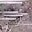

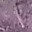

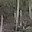

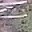

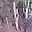

In [8]:
from IPython.display import Image, display
for i, img_path in enumerate(train_paths[0:5]):
    display(Image(img_path, width=200, height=200))

In [9]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

#image size
img_rows, img_cols, image_size = 32, 32, 32

def read_and_prep_images(img_paths, img_height=image_size, img_width=image_size):
    #avoid too many open files
    img_array = []
    for img_path in img_paths:
        img = load_img(img_path, target_size=(img_height, img_width))
        img_array.append(img_to_array(img))
        img.close() 
        
#     imgs = [load_img(img_path, target_size=(img_height, img_width)) for img_path in img_paths]
#     img_array = np.array([img_to_array(img) for img in imgs])
    output = prep_data(np.array(img_array))
    return(output)

#training data has its labels already split out
def prep_data(raw):
    x = raw[:,0:]
    num_images = raw.shape[0]
    out_x = x.reshape(num_images, img_rows, img_cols, 3)
    out_x = out_x / 255
    return out_x

In [10]:
train_data = read_and_prep_images(train_paths)
val_data = read_and_prep_images(val_paths)

In [11]:
np.shape(train_data)

(14000, 32, 32, 3)

In [12]:
from tensorflow import keras
#cactus or no
num_classes = 2

train_labels = keras.utils.to_categorical(Y_train, num_classes)
val_labels = keras.utils.to_categorical(Y_val, num_classes)

In [13]:
train_labels

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

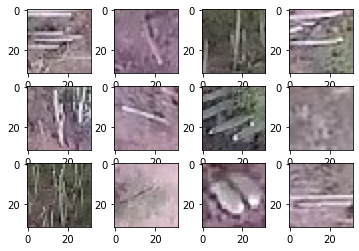

In [14]:
import matplotlib.pyplot as plt

#view a couple of the training images
for i in range(1,13):
    plt.subplot(3,4,i)
    plt.imshow(train_data[i-1])
#moar cacti

# Build a CNN

In [15]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D

#build the model
cactus_model = Sequential()
cactus_model.add(Conv2D(12, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(img_rows, img_cols, 3))) #activation layer

#additional learning layers
cactus_model.add(Conv2D(10, kernel_size=(3, 3), activation='relu'))
cactus_model.add(Conv2D(25, kernel_size=(3, 3), activation='relu'))
cactus_model.add(Conv2D(20, kernel_size=(3, 3), activation='relu'))
cactus_model.add(Conv2D(20, kernel_size=(3, 3), activation='relu'))

#final prediction layers
cactus_model.add(Flatten())
cactus_model.add(Dense(100, activation='relu'))
cactus_model.add(Dense(num_classes, activation='softmax'))

#compile the model
cactus_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

In [16]:
cactus_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 12)        336       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 10)        1090      
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 25)        2275      
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 20)        4520      
                                                                 
 conv2d_4 (Conv2D)           (None, 22, 22, 20)        3620      
                                                                 
 flatten (Flatten)           (None, 9680)              0         
                                                                 
 dense (Dense)               (None, 100)               9

In [17]:
#initial fit with validation
history = cactus_model.fit(train_data, train_labels,
          batch_size=100,
          epochs=1,
          validation_data = (val_data, val_labels))

140/140 [==============================] - 48s 332ms/step - loss: 0.3079 - accuracy: 0.8718 - val_loss: 0.1384 - val_accuracy: 0.9494


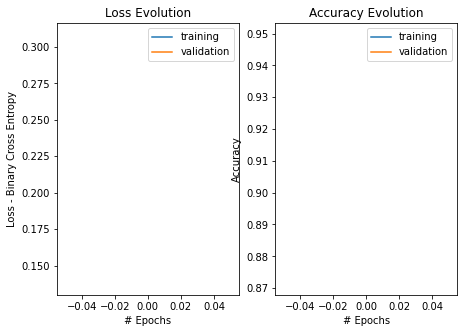

In [18]:
plt.figure(figsize=(15,5))

plt.subplot(141)
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('# Epochs')
plt.legend()
plt.ylabel("Loss - Binary Cross Entropy")
plt.title('Loss Evolution')

plt.subplot(142)
plt.plot(history.history['accuracy'], label='training')
plt.plot(history.history['val_accuracy'], label='validation')
plt.xlabel('# Epochs')
plt.ylabel("Accuracy")
plt.legend()
plt.title('Accuracy Evolution')
plt.show()

# Augmented Model

In [19]:
#build the model, same as above
cactus_model_aug = Sequential()
cactus_model_aug.add(Conv2D(12, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(img_rows, img_cols, 3))) #activation layer

#additional learning layers
cactus_model_aug.add(Conv2D(20, kernel_size=(3, 3), activation='relu'))
cactus_model_aug.add(Conv2D(20, kernel_size=(3, 3), activation='relu'))
cactus_model_aug.add(Conv2D(20, kernel_size=(3, 3), activation='relu'))
cactus_model_aug.add(Conv2D(20, kernel_size=(3, 3), activation='relu'))

#final prediction layers
cactus_model_aug.add(Flatten())
cactus_model_aug.add(Dense(100, activation='relu'))
cactus_model_aug.add(Dense(num_classes, activation='softmax'))

#compile the model
cactus_model_aug.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

datagen.fit(train_data)

In [21]:
history2 = cactus_model_aug.fit_generator(datagen.flow(train_data,train_labels),
                              epochs = 15, validation_data = (val_data,val_labels), steps_per_epoch=20)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


20/20 [==============================] - 7s 328ms/step - loss: 0.5495 - accuracy: 0.7203 - val_loss: 0.3995 - val_accuracy: 0.7506
Epoch 2/15
20/20 [==============================] - 6s 319ms/step - loss: 0.4057 - accuracy: 0.8172 - val_loss: 0.4531 - val_accuracy: 0.7843
Epoch 3/15
20/20 [==============================] - 10s 525ms/step - loss: 0.3382 - accuracy: 0.8906 - val_loss: 0.3327 - val_accuracy: 0.8714
Epoch 4/15
20/20 [==============================] - 7s 344ms/step - loss: 0.2538 - accuracy: 0.9000 - val_loss: 0.1948 - val_accuracy: 0.9369
Epoch 5/15
20/20 [==============================] - 6s 312ms/step - loss: 0.3730 - accuracy: 0.8797 - val_loss: 0.3679 - val_accuracy: 0.8111
Epoch 6/15
20/20 [==============================] - 6s 316ms/step - loss: 0.2847 - accuracy: 0.8828 - val_loss: 0.2223 - val_accuracy: 0.9277
Epoch 7/15
20/20 [==============================] - 6s 314ms/step - loss: 0.3762 - accuracy: 0.8469 - val_loss: 0.2387 - val_accuracy: 0.9174
Epoch 8/15
20/20

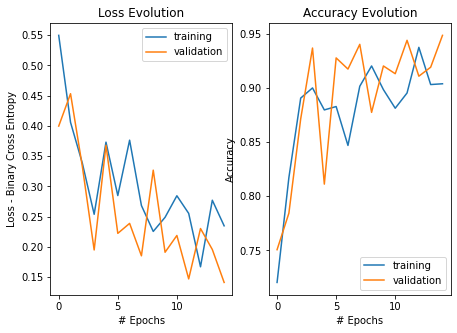

In [22]:
plt.figure(figsize=(15,5))

plt.subplot(141)
plt.plot(history2.history['loss'], label='training')
plt.plot(history2.history['val_loss'], label='validation')
plt.xlabel('# Epochs')
plt.legend()
plt.ylabel("Loss - Binary Cross Entropy")
plt.title('Loss Evolution')

plt.subplot(142)
plt.plot(history2.history['accuracy'], label='training')
plt.plot(history2.history['val_accuracy'], label='validation')
plt.xlabel('# Epochs')
plt.ylabel("Accuracy")
plt.legend()
plt.title('Accuracy Evolution')
plt.show()

# Evaluate Model Outputs

In [23]:
test_dir = 'input/test'
test_paths = [join(test_dir,filename) for filename in os.listdir(test_dir)]
test_paths[0:5]

['input/test/9247e189b9e152514d0dd5eb572a19ae.jpg',
 'input/test/9d0daf423d249ba7186e0180f7c721d1.jpg',
 'input/test/9d3ae1feadcdd5666b9822e9a9ea7be1.jpg',
 'input/test/f08153e6ebeb1cbcd9142eb8c77fcca8.jpg',
 'input/test/e0575dba73163736f438b2dc54118381.jpg']

In [24]:
len(os.listdir(test_dir))

4000

input/test/9247e189b9e152514d0dd5eb572a19ae.jpg


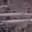

input/test/9d0daf423d249ba7186e0180f7c721d1.jpg


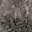

input/test/9d3ae1feadcdd5666b9822e9a9ea7be1.jpg


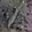

input/test/f08153e6ebeb1cbcd9142eb8c77fcca8.jpg


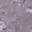

input/test/e0575dba73163736f438b2dc54118381.jpg


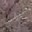

input/test/f340c8dc9995bb31502b248dc1104f8c.jpg


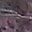

input/test/f686228a99e5ad5da3b3ba9a4435c310.jpg


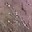

input/test/3893c5321f9d5d861610b4e016236377.jpg


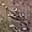

input/test/79fd59b03d929a8d5fb01b8916169eef.jpg


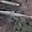

input/test/407a2e8c1e75d5434fbd8f48b4d108c1.jpg


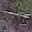

input/test/659da8317dd794dccfb5c0a06c56ed5b.jpg


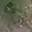

input/test/59ac3ca555d150b21884f7f2273d7449.jpg


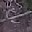

In [25]:
from IPython.display import Image, display
for i, img_path in enumerate(test_paths[0:12]):
    print(img_path)
    display(Image(img_path, width = 200, height = 200))

In [26]:
test_data = read_and_prep_images(test_paths)

In [27]:
np.shape(test_data)

(4000, 32, 32, 3)

In [28]:
#Get predictions
preds_test = cactus_model.predict(test_data)

# #the model returns a list of probabilities for each outcome. 
realPreds = preds_test[:,0]
[round(x, 2) for x in realPreds][0:12]

[0.1, 0.71, 0.08, 0.95, 0.47, 0.01, 0.83, 0.04, 0.01, 0.01, 0.94, 0.0]

In [29]:
# Save test predictions to file
# no aug performed better
output = pd.DataFrame({'id': os.listdir(test_dir),
                       'has_cactus': realPreds})
output.to_csv('submission.csv', index=False)

In [30]:
output.head()

,id,has_cactus
0,9247e189b9e152514d0dd5eb572a19ae.jpg,0.101920
1,9d0daf423d249ba7186e0180f7c721d1.jpg,0.709252
2,9d3ae1feadcdd5666b9822e9a9ea7be1.jpg,0.083591
3,f08153e6ebeb1cbcd9142eb8c77fcca8.jpg,0.948667
4,e0575dba73163736f438b2dc54118381.jpg,0.471546
